# Pre-processing for Elmer

## Description

investigate pre-processing of input data to Elmer, here import bed elevation data from BedMachine Antarctica to the Elmer grid. 

Compare different interpolation methods (e.g. linear interpolation from xarray, and conservative interpolation) and some examples to save and plot results...

In [1]:
import sys
import os
import xarray as xr
import xugrid as xu

from numba_celltree.celltree import(cast_vertices, cast_faces)
from scipy.sparse import *

sys.path.insert(0, os.path.abspath('../'))

from ElmerUgrid import ugrid
from ElmerUgrid.Interpolation import *
from ElmerUgrid.Projection import *
from ElmerUgrid.fem import TriIntegrate

# Get BedMachine data

In [2]:
## GBedMachine is stored as a netcdf on a regular grid; open it using xarray.
bdm = xr.open_dataset("../DATA/BedMachineAntarctica_v02_m.nc")

In [3]:
## coarsen the data for faster testing
step=4
data=bdm.coarsen(x=step,y=step,boundary="trim").mean()

print(data)

<xarray.Dataset> Size: 489MB
Dimensions:    (y: 3333, x: 3333)
Coordinates:
  * x          (x) float64 27kB -3.332e+06 -3.33e+06 ... 3.33e+06 3.332e+06
  * y          (y) float64 27kB 3.332e+06 3.33e+06 ... -3.33e+06 -3.332e+06
Data variables:
    thickness  (y, x) float32 44MB nan nan nan nan nan ... nan nan nan nan nan
    mapping    |S1 1B b''
    mask       (y, x) float64 89MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    firn       (y, x) float32 44MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    surface    (y, x) float32 44MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bed        (y, x) float32 44MB -5.918e+03 -5.94e+03 ... -3.63e+03 -3.661e+03
    errbed     (y, x) float32 44MB nan nan nan nan nan ... nan nan nan nan nan
    source     (y, x) float64 89MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    geoid      (y, x) float64 89MB -1.0 -0.9375 0.0 0.0 ... -19.0 -19.0 -19.0
Attributes: (12/19)
    Conventions:                 CF-1.7
    Title:                       BedM

# Load Elmer initial state

In [4]:
## this is justine ISMIP6 2300 initial state.
## the bedrock should have been linearly interpolated from the BedMachine data
tmp=xu.open_dataset("../DATA/elmer_antarctica_000.nc",decode_times=False)
## reminder xios save coordinates in lon/lat
tmp.ugrid.set_crs("EPSG:4326")
## reproject to the correct projection
ismip6_init=tmp.ugrid.to_crs("EPSG:3031")
elmer_grid=ismip6_init.bedrock.grid



In [5]:
## Plot data and elmer mesh
data.bed.plot()
elmer_grid.plot(color="black",linewidth=0.1)

# Linear interpolation

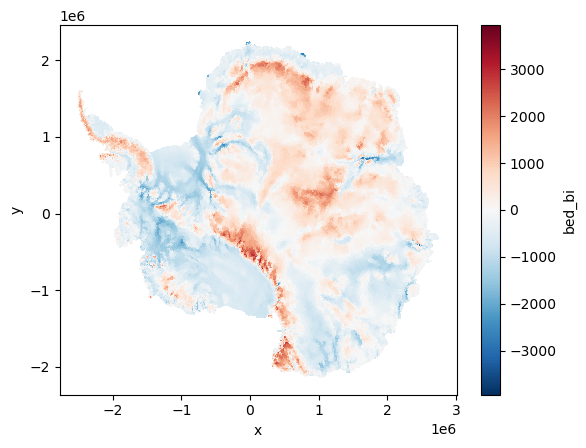

In [6]:
## xarray linear interpolation at the elmer mesh nodes:
points=elmer_grid.node_coordinates
x = xr.DataArray(points[:, 0], dims="points")
y = xr.DataArray(points[:, 1], dims="points")

interp=data.bed.interp(x=x,y=y,method="linear")

bed_bi=xu.UgridDataArray( xr.DataArray(
                        data=interp.values,
                        name="bed_bi",
                        dims=[elmer_grid.node_dimension],
                        attrs=dict(mesh=elmer_grid.name,location="node")),
                   elmer_grid) 
bed_bi.ugrid.plot()

difference with initial mesh values: rms 4.616329e+01


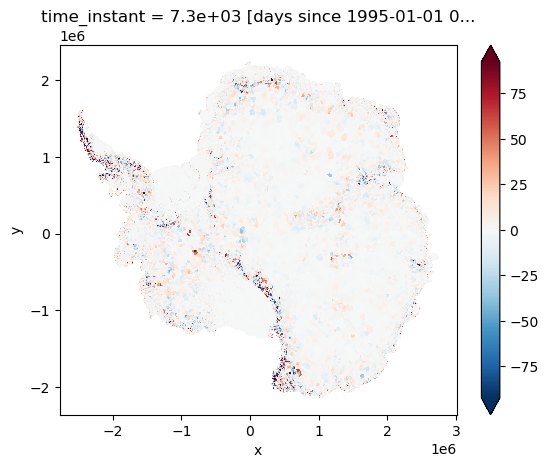

In [7]:
## just remind that elmer/xios results always ahave a time dimension
## so need to select the required time value to compare with a data sets without time dimension
db=ismip6_init.bedrock.isel(time=0)-bed_bi
rms=np.sqrt(np.mean(np.square(db.values)))
db.ugrid.plot(vmin=-2*rms,vmax=2*rms, cmap='RdBu_r')

print("difference with initial mesh values: rms %e"%(rms))
## normal to get (small?) differences if the input data has been coarsen

# Conservative interpolation

## Convert input regular data to xugrid

In [8]:
## This step can be very slow; tested up to coarsening 2. Haven't tried with the original grid.
## might be better to do this only ones and save the results to a file for latter use.
data_ugrid=xu.UgridDataArray.from_structured(data.bed)
print(data_ugrid)

<xarray.DataArray 'bed' (mesh2d_nFaces: 11108889)> Size: 44MB
array([-5917.82  , -5939.879 , -5956.5757, ..., -3580.3374, -3630.4927,
       -3660.5183], dtype=float32)
Coordinates:
  * mesh2d_nFaces  (mesh2d_nFaces) int64 89MB 0 1 2 ... 11108887 11108888


# Interpolation

## Native xugrid overlap

In [9]:
## assume that data are face_values
## results is a variable defined on the elements
regridder = xu.OverlapRegridder(source=data_ugrid, target=elmer_grid, method="mean")
result_mean = regridder.regrid(data_ugrid)
result_mean.ugrid.plot()

## Do it again with home made code

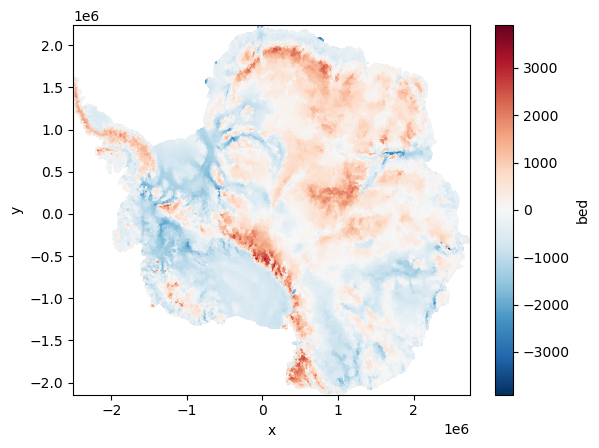

In [10]:
data_grid=data_ugrid.grid

target_vertices=cast_vertices(elmer_grid.node_coordinates)
target_faces=cast_faces(elmer_grid.face_node_connectivity,elmer_grid.fill_value)

source_vertices=cast_vertices(data_grid.node_coordinates)
source_faces=cast_faces(data_grid.face_node_connectivity, data_grid.fill_value)

## Compute the intersection between source and target faces 
target_indices,source_indices=data_grid.celltree._locate_faces(target_vertices,target_faces)

## Conservative face to face interpolation weights for the gradient
weights_f,target_face_index_f,source_face_index_f=face_2_face_interpolation(
            vertices_a=target_vertices,
            vertices_b=source_vertices,
            faces_a=target_faces,
            faces_b=source_faces,
            indices_a=target_indices,
            indices_b=source_indices,
        )


Mf = coo_matrix((weights_f,(target_face_index_f,source_face_index_f)), shape=(elmer_grid.n_face,data_grid.n_face) )
Mf=Mf.tocsr()

face_ones=np.ones(data_grid.n_face,dtype=np.float64)
intersect_area=Mf*face_ones

bed_f_i=Mf*data_ugrid.values
bed_f_i /= intersect_area

result_2 = xr.DataArray(
    data=bed_f_i,
    name="bed",
    dims=[elmer_grid.face_dimension],
    attrs=dict(mesh=elmer_grid.name,location="face"))
    
result_2 = xu.UgridDataArray(result_2, elmer_grid)

result_2.ugrid.plot()

## Compare the two solutions

diffrence min: -2.046363e-12 max: 3.183231e-12 mean:-7.778860e-17


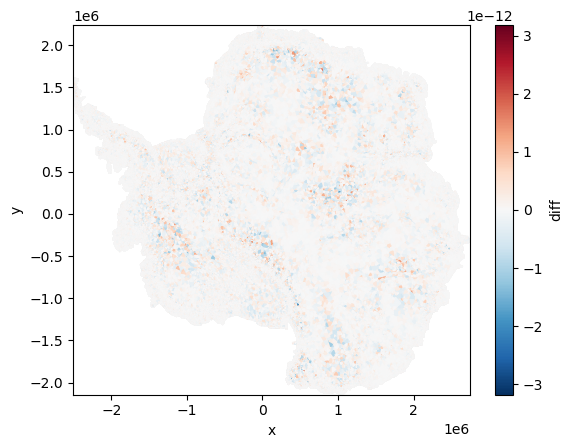

In [11]:
diff=result_mean.values-result_2.values
print("diffrence min: %e max: %e mean:%e"%(diff.min(),diff.max(),diff.mean()))
diff_da = xu.UgridDataArray(
            xr.DataArray(
                data=diff,
                name="diff",
                dims=[elmer_grid.face_dimension],
                attrs=dict(mesh=elmer_grid.name,location="face")),elmer_grid)
diff_da.ugrid.plot()

### project face values to nodes

In [12]:
face_values=result_2.values
zero_values=np.zeros((elmer_grid.n_face,2))

result_n=face_2_node_projection(face_values=face_values,
                               grad_values=zero_values,
                               nn=elmer_grid.n_node,
                               faces=elmer_grid.face_node_connectivity,
                               facesx=elmer_grid.face_coordinates,
                               nodes=elmer_grid.face_node_coordinates
                               )

res_da = xu.UgridDataArray(
            xr.DataArray(
                data=result_n,
                name="bed_ci",
                dims=[elmer_grid.node_dimension],
                attrs=dict(mesh=elmer_grid.name,location="node")),elmer_grid)
res_da.ugrid.plot()

## We could also compute and interpolate the gradient from the input grid for the face2node projection..

In [13]:
## Plot the difference
diff=bed_bi-res_da
rms=np.sqrt(np.mean(np.square(diff.values)))
print("difference between cons. and linear: rms %e"%(rms))
diff.ugrid.plot(vmin=-2*rms,vmax=2*rms, cmap='RdBu_r')

difference between cons. and linear: rms 3.837832e+01


## Compare the integrated results 

In [14]:
faces=cast_faces(elmer_grid.face_node_connectivity,elmer_grid.fill_value)

## The conservatively interpolated data: reprojected on the nodes
values=res_da.values
int1=TriIntegrate(values=values,
                  faces=faces,
                  nodes=elmer_grid.face_node_coordinates)

## The linearly interpolated data
values=bed_bi.values
int2=TriIntegrate(values=values,
                  faces=faces,
                  nodes=elmer_grid.face_node_coordinates)

## the conservativley interpolated face data
int3=(result_mean.values*elmer_grid.area).sum()

print("integrated results : cons.: %e linear: %e cons. face values: %e"%(int1,int2,int3))
## Rq. the prjection from the elments to the nodes is conservative; so we should get the same results.

integrated results : cons.: -3.735056e+13 linear: -4.073360e+13 cons. face values: -3.735056e+13


## save results as an UGRID netcdf

In [15]:
## Create a data set
ds=xu.UgridDataset(grids=elmer_grid)
ds["linear"]=bed_bi
ds["conservative"]=res_da
ds["elmer"]=ismip6_init.bedrock.isel(time=0)

## There is a pb to open the data on paraview if using the raw ugrid.to_netcdf();
## issue is related to order of the variable in the file
## use home made function...
## don't forget to define the "mesh" and "location" attributes when creata dataArrays
ds.ugrid.to_netcdf_forpv("BedMachineOnElmer.nc")

## Test on other meshes...

Rq. the different Elmer grids do not have perfectly matching boundaries; so it is expected to have non null diferences between the integrated results even with conservative schemes. However, variability is much smaller than the linear interpolation. See results below.

### Mesh 1

In [16]:
tmp=xu.open_dataset("../DATA/result_abuk1b_1_5_0.nc",decode_times=False)
tmp.ugrid.set_crs("EPSG:4326")
proj=tmp.ugrid.to_crs("EPSG:3031")
elmer_grid=proj.bedrock.grid

In [17]:
## Plot data and elmer mesh
data.bed.plot()
elmer_grid.plot(color="black",linewidth=0.1)

In [18]:
## Linear Interpolation
points=elmer_grid.node_coordinates
x = xr.DataArray(points[:, 0], dims="points")
y = xr.DataArray(points[:, 1], dims="points")

interp=data.bed.interp(x=x,y=y,method="linear")

bed_bi=xu.UgridDataArray( xr.DataArray(
                        data=interp.values,
                        name="bed_bi",
                        dims=[elmer_grid.node_dimension],
                        attrs=dict(mesh=elmer_grid.name,location="node")),
                   elmer_grid) 
#bed_bi.ugrid.plot()

In [19]:
## we can use the native overlap
regridder = xu.OverlapRegridder(source=data_ugrid, target=elmer_grid, method="mean")
result_mean = regridder.regrid(data_ugrid)
#result_mean.ugrid.plot()

## project to nodes
face_values=result_mean.values
zero_values=np.zeros((elmer_grid.n_face,2))

result_n=face_2_node_projection(face_values=face_values,
                               grad_values=zero_values,
                               nn=elmer_grid.n_node,
                               faces=elmer_grid.face_node_connectivity,
                               facesx=elmer_grid.face_coordinates,
                               nodes=elmer_grid.face_node_coordinates
                               )

res_da = xu.UgridDataArray(
            xr.DataArray(
                data=result_n,
                name="bed",
                dims=[elmer_grid.node_dimension],
                attrs=dict(mesh=elmer_grid.name,location="node")),elmer_grid)



In [20]:
## Plot the difference between linear and conservative
diff=bed_bi-res_da
rms=np.sqrt(np.mean(np.square(diff.values)))
print("difference between cons. and linear: rms %e"%(rms))
diff.ugrid.plot(vmin=-2*rms,vmax=2*rms, cmap='RdBu_r')

## and compute the integrated value
faces=cast_faces(elmer_grid.face_node_connectivity,elmer_grid.fill_value)
values=res_da.values
int1=TriIntegrate(values=values,
                  faces=faces,
                  nodes=elmer_grid.face_node_coordinates)

values=proj.bedrock.isel(time=0).values
int2=TriIntegrate(values=values,
                  faces=faces,
                  nodes=elmer_grid.face_node_coordinates)

print("integrated results : cons.: %e linear: %e"%(int1,int2))


difference between cons. and linear: rms 3.490749e+01
integrated results : cons.: -3.729515e+13 linear: -4.536064e+13


### Mesh 2

In [21]:
tmp=xu.open_dataset("../DATA/result_abuk1b_2_5_0.nc",decode_times=False)
tmp.ugrid.set_crs("EPSG:4326")
proj=tmp.ugrid.to_crs("EPSG:3031")
elmer_grid=proj.bedrock.grid

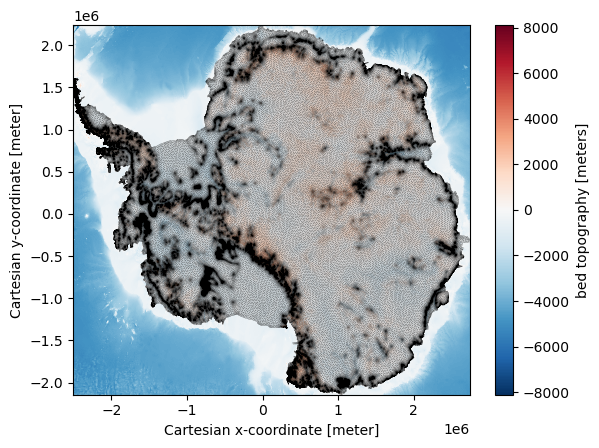

In [22]:
## Plot data and elmer mesh
data.bed.plot()
elmer_grid.plot(color="black",linewidth=0.1)

In [23]:
## Linear Interpolation
points=elmer_grid.node_coordinates
x = xr.DataArray(points[:, 0], dims="points")
y = xr.DataArray(points[:, 1], dims="points")

interp=data.bed.interp(x=x,y=y,method="linear")

bed_bi=xu.UgridDataArray( xr.DataArray(
                        data=interp.values,
                        name="bed_bi",
                        dims=[elmer_grid.node_dimension],
                        attrs=dict(mesh=elmer_grid.name,location="node")),
                   elmer_grid) 
#bed_bi.ugrid.plot()

In [24]:
## Conservative interpolation
regridder = xu.OverlapRegridder(source=data_ugrid, target=elmer_grid, method="mean")
result_mean = regridder.regrid(data_ugrid)
#result_mean.ugrid.plot()

## project to nodes
face_values=result_mean.values
zero_values=np.zeros((elmer_grid.n_face,2))

result_n=face_2_node_projection(face_values=face_values,
                               grad_values=zero_values,
                               nn=elmer_grid.n_node,
                               faces=elmer_grid.face_node_connectivity,
                               facesx=elmer_grid.face_coordinates,
                               nodes=elmer_grid.face_node_coordinates
                               )

res_da = xu.UgridDataArray(
            xr.DataArray(
                data=result_n,
                name="bed",
                dims=[elmer_grid.node_dimension],
                attrs=dict(mesh=elmer_grid.name,location="node")),elmer_grid)



difference between cons. and linear: rms 4.313661e+01
integrated results : cons.: -3.715706e+13 linear: -3.870751e+13


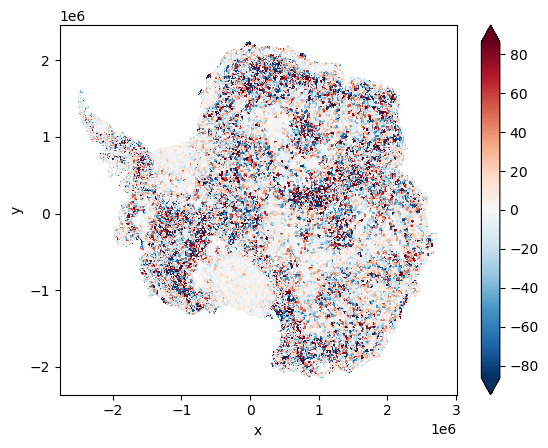

In [25]:
## Plot the difference between linear and conservative
diff=bed_bi-res_da
rms=np.sqrt(np.mean(np.square(diff.values)))
print("difference between cons. and linear: rms %e"%(rms))
diff.ugrid.plot(vmin=-2*rms,vmax=2*rms, cmap='RdBu_r')

## and compute the integrated value
faces=cast_faces(elmer_grid.face_node_connectivity,elmer_grid.fill_value)
values=res_da.values
int1=TriIntegrate(values=values,
                  faces=faces,
                  nodes=elmer_grid.face_node_coordinates)

values=proj.bedrock.isel(time=0).values
int2=TriIntegrate(values=values,
                  faces=faces,
                  nodes=elmer_grid.face_node_coordinates)

print("integrated results : cons.: %e linear: %e"%(int1,int2))

# Some plotting examples

mesh2d_s
mesh2d


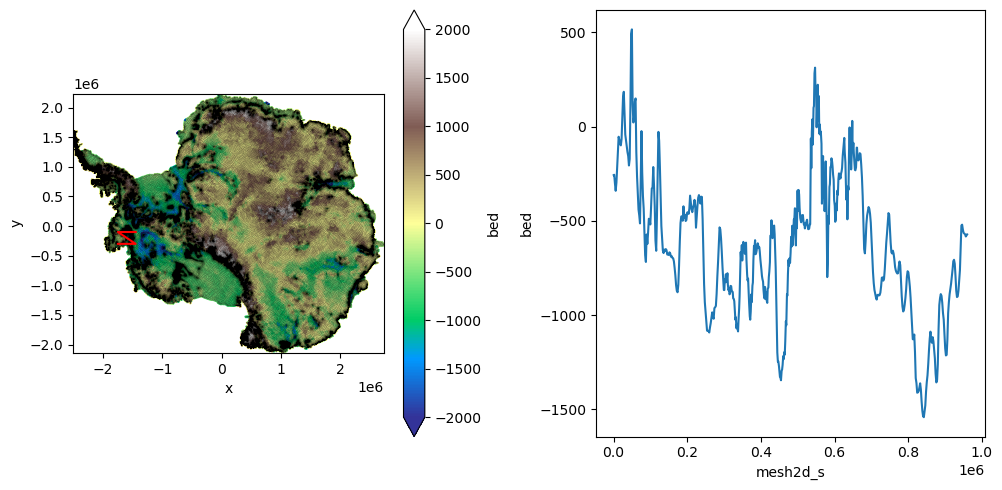

In [26]:
import shapely
import matplotlib.pyplot as plt


def show_line_selection(uda, da,axis_name, line_x=None, line_y=None):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
    uda.ugrid.plot(ax=ax0, vmin=-2000, vmax=2000, cmap="terrain")
    uda.ugrid.plot.line(color="black",linewidth=0.1,ax=ax0)
    da.plot(ax=ax1, x=axis_name)
    if line_x is None:
        ax0.axhline(line_y, color="red")
    elif line_y is None:
        ax0.axvline(line_x, color="red")
    else:
        ax0.plot(line_x, line_y, color="red")
    ax0.set_aspect(1.0)
    fig.tight_layout()



linestring = shapely.geometry.LineString(
    [
        (-1.75e6, -3.0e5),
        (-1.45e6, -3.0e5),
        (-1.75e6, -1.0e5),
        (-1.45e6, -1.0e5),
    ]
)


## Ugrid interpolation; e.g. intersect_linestring only works for variables defined on the elements
## we can first to an interpolation for a face vraible; or here on the input ugrid_data;
## then use barycentric interpolation for nodal variables

## Rq. coordinate names inherit name from the input
## so will be mesh2d if we interpolate from bedmachine
## or mesh2D if we interpolate from an Elmer mesh...

da = data_ugrid.ugrid.intersect_linestring(linestring)
#print(da)
axis_name=data_ugrid.grid.name+"_s"
print(axis_name)
show_line_selection(result_mean, da,axis_name, *shapely.get_coordinates(linestring).T)


print(data_ugrid.grid.name)

In [27]:
## Baricentric interpolation at the given points
points=np.vstack((da.mesh2d_x.values,da.mesh2d_y.values)).T

M,out = barycentric_interpolator(points, elmer_grid)

out=M*res_da.values
out2=M*bed_bi.values

#print(da.data)

#print(da[axis_name].values)

plt.plot(da[axis_name].values,da.data,color="black") ## the input data
plt.plot(da[axis_name].values,out,color="blue") ## the conservative interpolation
plt.plot(da[axis_name].values,out2,color="red") ## the linear interpolation


<xarray.Dataset> Size: 24kB
Dimensions:        (mesh2d_nFaces: 553)
Coordinates:
  * mesh2d_nFaces  (mesh2d_nFaces) int64 4kB 6053519 6053520 ... 5720368 5720369
    mesh2d_s       (mesh2d_nFaces) float64 4kB 375.0 1.75e+03 ... 9.599e+05
    mesh2d_x       (mesh2d_nFaces) float64 4kB -1.75e+06 ... -1.451e+06
    mesh2d_y       (mesh2d_nFaces) float64 4kB -3e+05 -3e+05 ... -1e+05 -1e+05
Data variables:
    bed            (mesh2d_nFaces) float32 2kB -256.9 -255.2 ... -576.3 -571.6
    test           (mesh2d_nFaces) float64 4kB -269.7 -280.1 ... -587.6 -586.9
('mesh2d_nFaces',)


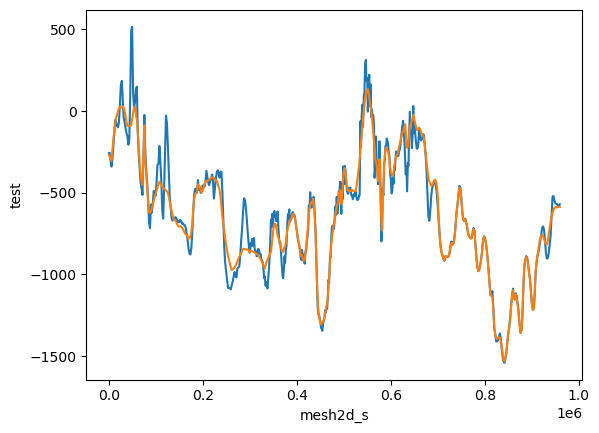

In [28]:
## the linestring result is a xr.data array
## we can create data arrays
new_da=xr.DataArray(
                data=out,
                name="test",
                dims=da.dims)
ds=xr.merge([da,new_da])
print(ds)
ds.bed.plot(x="mesh2d_s")
ds.test.plot(x="mesh2d_s")

print(da.dims)